# Exploratory Analysis

Group project for the 2019 Data Science Workshop hosted by the Graduate Data Science Organization at the University of California, Berkeley.

The project is the Google Analytics Customer Revenue Prediction competition on Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction

Group members:

* Andy Vargas (mentor)
* Yuem Park
* Marvin Pohl
* Michael Yeh

In [1]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy.stats import linregress
import datetime as dt

from sklearn.preprocessing import LabelBinarizer

pd.options.display.max_columns = 999

## Seasonality?

In [2]:
# this small_cleaned data file was created during an earlier iteration of this notebook...
train_small = pd.read_csv('./data/train_small_cleaned.csv', dtype={'fullVisitorId':'str'})

train_small['date'] = pd.to_datetime(train_small['date'], format='%Y%m%d')

train_small_rev = train_small[train_small['totals.transactionRevenue']>0]

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


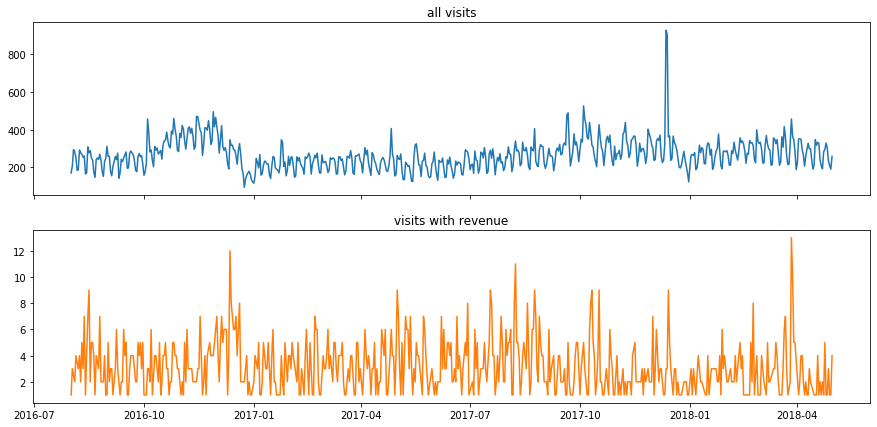

In [3]:
date_val_counts_all = train_small['date'].value_counts()
date_val_counts_rev = train_small_rev['date'].value_counts()

date_val_counts_all.sort_index(inplace=True)
date_val_counts_rev.sort_index(inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,7))

ax[0].plot(date_val_counts_all.index, date_val_counts_all, c='C0')
ax[0].set_title('all visits')

ax[1].plot(date_val_counts_rev.index, date_val_counts_rev, c='C1')
ax[1].set_title('visits with revenue')

plt.show(fig)

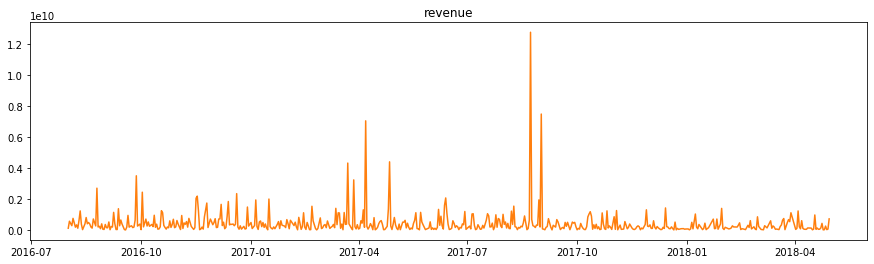

In [4]:
date_rev_sum_rev = train_small_rev.groupby('date')['totals.transactionRevenue'].sum()
date_rev_sum_rev.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(15,4))

ax.plot(date_rev_sum_rev.index, date_rev_sum_rev, c='C1')
ax.set_title('revenue')

plt.show(fig)

## Load data

Note that the data files are too large to upload to GitHub - instead, the directory `./data/` has been added to the .gitignore, which should contain the following files on your local machine, all downloaded from the Kaggle competition website:

* sample_submission_v2.csv
* test_v2.csv
* train_v2.csv

Time windows we are interested in:

In [5]:
train_start_date = dt.datetime(2016, 8, 1)
train_end_date = dt.datetime(2018, 4, 30)
train_duration = train_end_date - train_start_date + dt.timedelta(days=1)
print('train duration = {} days'.format(train_duration.days))

train duration = 638 days


In [6]:
test_start_date = dt.datetime(2018, 5, 1)
test_end_date = dt.datetime(2018, 10, 15)
test_duration = test_end_date - test_start_date + dt.timedelta(days=1)
print('test duration = {} days'.format(test_duration.days))

test duration = 168 days


In [7]:
predict_start_date = dt.datetime(2018, 12, 1)
predict_end_date = dt.datetime(2019, 1, 31)
predict_duration = predict_end_date - predict_start_date + dt.timedelta(days=1)
print('predict duration = {} days'.format(predict_duration.days))

predict duration = 62 days


In [8]:
gap_duration = predict_start_date - test_end_date - dt.timedelta(days=1)
print('gap duration = {} days'.format(gap_duration.days))

gap duration = 46 days


What is the last day we can start a training time window on?

In [9]:
train_end_date - (test_duration + predict_duration + gap_duration)

datetime.datetime(2017, 7, 28, 0, 0)

5 slices in total:

In [10]:
train_start_date

datetime.datetime(2016, 8, 1, 0, 0)

In [11]:
train_start_date + ((((train_end_date - (test_duration + predict_duration + gap_duration)) - train_start_date)/4)*1)

datetime.datetime(2016, 10, 30, 6, 0)

In [12]:
train_start_date + ((((train_end_date - (test_duration + predict_duration + gap_duration)) - train_start_date)/4)*2)

datetime.datetime(2017, 1, 28, 12, 0)

In [13]:
train_start_date + ((((train_end_date - (test_duration + predict_duration + gap_duration)) - train_start_date)/4)*3)

datetime.datetime(2017, 4, 28, 18, 0)

In [14]:
train_end_date - (test_duration + predict_duration + gap_duration)

datetime.datetime(2017, 7, 28, 0, 0)

Now read in the data:

In [15]:
# to read in a previously created and cleaned slice, set this to False
create_slice = False

# set slice dates here
#slice_start_date = dt.datetime(2016, 8, 1) #01
#slice_start_date = dt.datetime(2016, 10, 30) #02
#slice_start_date = dt.datetime(2017, 1, 28) #03
#slice_start_date = dt.datetime(2017, 4, 28) #04
#slice_start_date = dt.datetime(2017, 7, 28) #05
slice_start_date = dt.datetime(2017, 5, 1) #match

# set identifier here
str_append = 'match'

In [16]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId':'str'}) # Important!!
    
    # just ignore the hits and customDimensions columns for now...
    df.drop(['hits','customDimensions'], axis=1, inplace=True)
    # fix the formatting in these two columns, and convert them into lists of dictionaries
    #df['hits'] = df['hits'].str.replace("{'", '{"')
    #df['hits'] = df['hits'].str.replace("'}", '"}')
    #df['hits'] = df['hits'].str.replace(": '", ': "')
    #df['hits'] = df['hits'].str.replace("',", '",')
    #df['hits'] = df['hits'].str.replace(", '", ', "')
    #df['hits'] = df['hits'].str.replace("':", '":')
    #df['hits'] = df['hits'].str.replace("\'", "'")
    #df['hits'] = df['hits'].str.replace('"7" ', '"7in ')
    #df['hits'] = df['hits'].str.replace('/7" ', '/7in ')
    #df['hits'] = df['hits'].str.replace('"Player"', "'Player'")
    #df['hits'] = df['hits'].str.replace('True', 'true')
    #df['hits'] = df['hits'].str.replace('False', 'false')
    #df['hits'] = df['hits'].apply(json.loads)
    
    #df['customDimensions'] = df['customDimensions'].str.replace("{'", '{"')
    #df['customDimensions'] = df['customDimensions'].str.replace("'}", '"}')
    #df['customDimensions'] = df['customDimensions'].str.replace(": '", ': "')
    #df['customDimensions'] = df['customDimensions'].str.replace("',", '",')
    #df['customDimensions'] = df['customDimensions'].str.replace(", '", ', "')
    #df['customDimensions'] = df['customDimensions'].str.replace("':", '":')
    #df['customDimensions'] = df['customDimensions'].str.replace("\'", "'")
    #df['customDimensions'] = df['customDimensions'].str.replace('True', 'true')
    #df['customDimensions'] = df['customDimensions'].str.replace('False', 'false')
    #df['customDimensions'] = df['customDimensions'].apply(json.loads)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [17]:
if create_slice == True:
    
    # slice
    slice_end_date = slice_start_date + test_duration - dt.timedelta(days=1)
    predict_slice_start_date = slice_end_date + gap_duration - dt.timedelta(days=1)
    predict_slice_end_date = predict_slice_start_date + predict_duration - dt.timedelta(days=1)
    
    # read in .csv, and covert the date column to datetime
    train = pd.read_csv('./data/train_v2.csv',dtype={'fullVisitorId':'str'})
    print('1/4 : Raw training read in.')
    train_date = pd.to_datetime(train['date'], format='%Y%m%d')
    
    # slice out train dataframe
    train_slice = train[(train_date>=slice_start_date) & (train_date<=slice_end_date)]
    train_predict_slice = train[(train_date>=predict_slice_start_date) & (train_date<=predict_slice_end_date)]
    
    # reset indexes
    train_slice.reset_index(inplace=True,drop=True)
    train_predict_slice.reset_index(inplace=True,drop=True)
    
    # save to .csv
    train_slice.to_csv('./data/train_slice_'+str_append+'.csv', index=False)
    train_predict_slice.to_csv('./data/train_predict_slice_'+str_append+'.csv', index=False)
    
    # load .csv's back in, but using the loading function to flatten most of the JSON columns
    train_slice = load_df('./data/train_slice_'+str_append+'.csv')
    train_predict_slice = load_df('./data/train_predict_slice_'+str_append+'.csv')
    print('2/4 : Sliced training read in.')
    
    # only keep the target column for the prediction slice
    train_predict_slice = train_predict_slice[['fullVisitorId','totals.transactionRevenue']]
    
    # remove columns that have no information from the training slice
    NA_cols = []
    for col in train_slice.columns:
        if col!='hits' and col!='customDimensions':
            if train_slice[col].nunique(dropna=False)==1:
                NA_cols.append(col)
    train_slice.drop(NA_cols, axis=1, inplace=True)
    print('3/4 : Bad columns dropped.')
    
    # save to .csv
    train_slice.to_csv('./data/train_slice_cleaned_'+str_append+'.csv', index=False)
    train_predict_slice.to_csv('./data/train_predict_slice_cleaned_'+str_append+'.csv', index=False)
    print('4/4 : Cleaned data saved.')
    
else:
    train_slice = pd.read_csv('./data/train_slice_cleaned_'+str_append+'.csv',
                              dtype={'fullVisitorId':'str'})
    train_predict_slice = pd.read_csv('./data/train_predict_slice_cleaned_'+str_append+'.csv',
                                      dtype={'fullVisitorId':'str'})

In [18]:
train_slice.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.sessionQualityDim,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.keyword
0,Organic Search,20170623,8220376077399595986,1498223351,1,1498223351,Chrome,Windows,False,desktop,Americas,South America,Argentina,Buenos Aires,(not set),Buenos Aires,iplannetworks.net,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20170623,1000831944282857356,1498232484,2,1498232484,Chrome,Macintosh,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,cybercable.net.mx,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20170623,7830153712423772213,1498237863,1,1498237863,Chrome,Macintosh,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,rima-tde.net,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Direct,20170623,6641049248090905193,1498223514,1,1498223514,Safari,iOS,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,virginm.net,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20170623,9993372776950522771,1498218717,1,1498218717,Safari,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,verizon.net,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
train_predict_slice.head()

,fullVisitorId,totals.transactionRevenue
0,0866679478270608956,NaN
1,8888363924006866238,NaN
2,0626622161982324192,NaN
3,4240687051629300635,NaN
4,4171334319241484308,NaN


Use the following to identify json load errors...:

## Simple exploration

In [20]:
train_slice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425146 entries, 0 to 425145
Data columns (total 38 columns):
channelGrouping                                 425146 non-null object
date                                            425146 non-null int64
fullVisitorId                                   425146 non-null object
visitId                                         425146 non-null int64
visitNumber                                     425146 non-null int64
visitStartTime                                  425146 non-null int64
device.browser                                  425146 non-null object
device.operatingSystem                          425146 non-null object
device.isMobile                                 425146 non-null bool
device.deviceCategory                           425146 non-null object
geoNetwork.continent                            425146 non-null object
geoNetwork.subContinent                         425146 non-null object
geoNetwork.country                         

### Target

In [21]:
train_predict_slice['fullVisitorId'].value_counts().head()

0827807801897731454    123
5211936831694160345     79
5787011031371430224     77
1322101426801959631     68
1828401299772351150     68
Name: fullVisitorId, dtype: int64

In [22]:
target = train_predict_slice.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
target.sort_index(inplace=True)
target = pd.DataFrame({'fullVisitorId':target.index,
                       'total_predict_revenue':target.values})

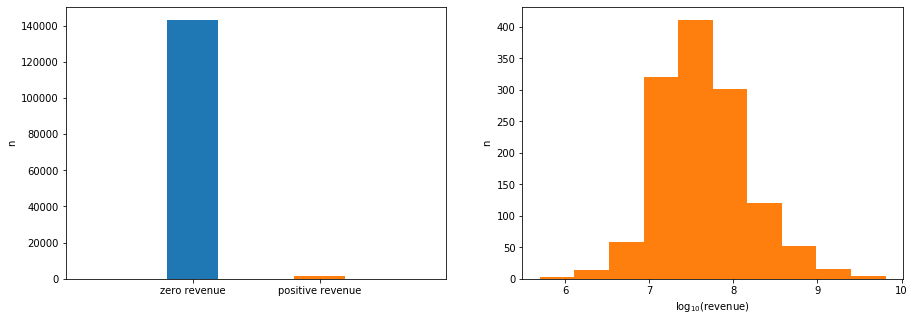

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

ax[0].bar([0,1],
          [len(target[target['total_predict_revenue']==0]),len(target[target['total_predict_revenue']!=0])],
          width=0.4, color=['C0','C1'])
ax[0].set_xlim(-1,2)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['zero revenue', 'positive revenue'])
ax[0].set_ylabel('n')

ax[1].hist(np.log10(target[target['total_predict_revenue']!=0]['total_predict_revenue']), color='C1')
ax[1].set_xlabel('log$_{10}$(revenue)')
ax[1].set_ylabel('n')

plt.show(fig)

Add a column that denotes:

* if the visitor did not return in the prediction slice: "DNR"
* if the visitor returned in the prediction slice but did not generate any revenue: "RZR"
* if the visitor returned in the prediction slice and generated revenue: "RPR"

In [24]:
# sort by visitor ID
train_slice.sort_values('fullVisitorId', inplace=True)
train_slice.reset_index(drop=True, inplace=True)

# merge the prediction and training slices on the full-visitor ID
train_slice = train_slice.merge(target, how='left', on='fullVisitorId')

In [25]:
train_slice.loc[train_slice['total_predict_revenue'].isnull(), 'prediction_flag'] = 'DNR'
train_slice.loc[train_slice['total_predict_revenue']==0, 'prediction_flag'] = 'RZR'
train_slice.loc[train_slice['total_predict_revenue']>0, 'prediction_flag'] = 'RPR'

Pull out some start time information:

In [26]:
train_slice['visitStartTime_hour'] = pd.to_datetime(train_slice['visitStartTime'], unit='s').dt.hour
train_slice['visitStartTime_day'] = pd.to_datetime(train_slice['visitStartTime'], unit='s').dt.weekday
train_slice['visitStartTime_month'] = pd.to_datetime(train_slice['visitStartTime'], unit='s').dt.month

Divide into 4 equal time periods - each exactly 6 weeks long:

In [27]:
# set slice dates here
p1_start_date = slice_start_date
p1_end_date = p1_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

p2_start_date = p1_end_date + dt.timedelta(days=1)
p2_end_date = p2_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

p3_start_date = p2_end_date + dt.timedelta(days=1)
p3_end_date = p3_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

p4_start_date = p3_end_date + dt.timedelta(days=1)
p4_end_date = p4_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

# create the column
train_date = pd.to_datetime(train_slice['date'], format='%Y%m%d')

train_slice.loc[(train_date>=p1_start_date) & (train_date<=p1_end_date), 'period'] = 1
train_slice.loc[(train_date>=p2_start_date) & (train_date<=p2_end_date), 'period'] = 2
train_slice.loc[(train_date>=p3_start_date) & (train_date<=p3_end_date), 'period'] = 3
train_slice.loc[(train_date>=p4_start_date) & (train_date<=p4_end_date), 'period'] = 4

Split the dataframes:

In [28]:
train_slice_DNR = train_slice[train_slice['prediction_flag']=='DNR']
train_slice_RZR = train_slice[train_slice['prediction_flag']=='RZR']
train_slice_RPR = train_slice[train_slice['prediction_flag']=='RPR']

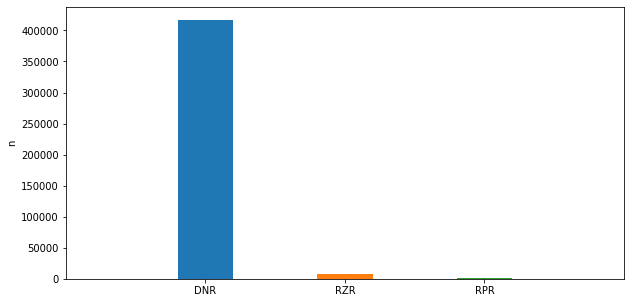

In [29]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar([0,1,2],
       [len(train_slice_DNR),len(train_slice_RZR),len(train_slice_RPR)],
       width=0.4, color=['C0','C1','C2'])
ax.set_xlim(-1,3)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['DNR', 'RZR', 'RPR'])
ax.set_ylabel('n')

plt.show(fig)

### Categorical features

Look at categorical variables:

In [30]:
def value_count_plot(feature):
    """
    Make a value count plot for categorical features.
    
    Parameters
    ----------
    feature : str
        Name of feature.
    """
    value_counts = train_slice[feature].value_counts(dropna=False)
    
    fig, ax = plt.subplots(figsize=(15,7))
    
    ax.plot(np.arange(len(value_counts)), value_counts, 'o-')
    
    ax.set_xlabel('category index')
    ax.set_ylabel('n')
    
    return fig, ax

In [31]:
def three_bars(feature):
    """
    Make bar plots that compare DNR, RZR, RPR for categorical features.
    
    Parameters
    ----------
    feature : str
        Name of feature.
    """
    unique_vals = train_slice[feature].unique()
    n_vals = len(unique_vals)

    val_counts_DNR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
        else:
            val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])

    val_counts_RZR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
        else:
            val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])

    val_counts_RPR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
        else:
            val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('DNR')

    ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('RZR')

    ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('RPR')

    plt.show(fig)

In [32]:
def three_bars_OTHER(feature, unique_vals):
    """
    Make bar plots that compare DNR, RZR, RPR for categorical features, including OTHER.
    
    Parameters
    ----------
    feature : str
        Name of feature.
        
    unique_vals : list
        List of categories - must include 'OTHER' as the last item.
    """
    n_vals = len(unique_vals)

    val_counts_DNR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])
            else:
                val_counts_DNR[i] = len(train_slice_DNR) - np.sum(val_counts_DNR)

    val_counts_RZR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])
            else:
                val_counts_RZR[i] = len(train_slice_RZR) - np.sum(val_counts_RZR)

    val_counts_RPR = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])
            else:
                val_counts_RPR[i] = len(train_slice_RPR) - np.sum(val_counts_RPR)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('DNR')

    ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('RZR')

    ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('RPR')

    plt.show(fig)

#### channelGrouping

In [33]:
train_slice['channelGrouping'].value_counts(dropna=False)

Organic Search    207203
Direct             69846
Referral           52399
Social             41833
Display            33368
Paid Search        12682
Affiliates          7807
(Other)                8
Name: channelGrouping, dtype: int64

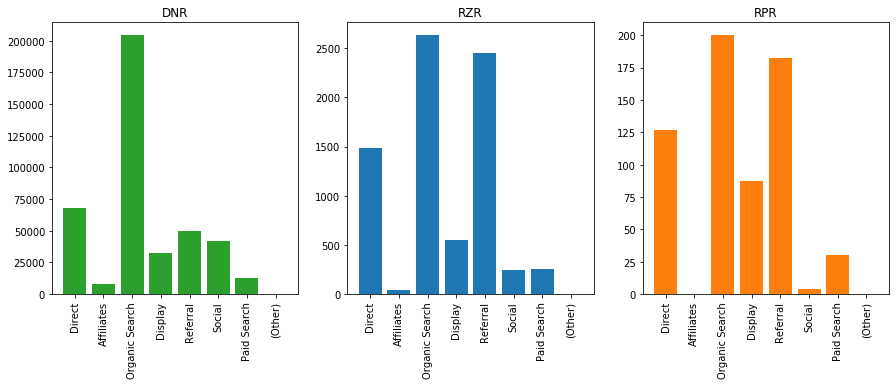

In [34]:
three_bars('channelGrouping')

#### device.browser

In [35]:
train_slice['device.browser'].value_counts(dropna=False)

Chrome                                         294833
Safari                                          77585
Firefox                                         15182
Internet Explorer                                7307
Android Webview                                  7113
Samsung Internet                                 6743
Edge                                             4612
Safari (in-app)                                  3727
Opera Mini                                       3287
Opera                                            1687
UC Browser                                       1470
Amazon Silk                                       384
YaBrowser                                         328
Android Browser                                   227
Coc Coc                                           213
Mozilla Compatible Agent                          138
Maxthon                                            72
Puffin                                             66
BlackBerry                  

In [36]:
train_slice_RZR['device.browser'].value_counts(dropna=False)

Chrome               6063
Safari               1105
Samsung Internet      169
Internet Explorer     116
Firefox               109
Edge                   44
Android Webview        22
Opera Mini             12
Safari (in-app)         6
Opera                   5
UC Browser              2
Amazon Silk             2
BlackBerry              1
Name: device.browser, dtype: int64

In [37]:
train_slice_RPR['device.browser'].value_counts(dropna=False)

Chrome               355
Firefox              220
Internet Explorer     43
Safari                 7
Edge                   5
Name: device.browser, dtype: int64

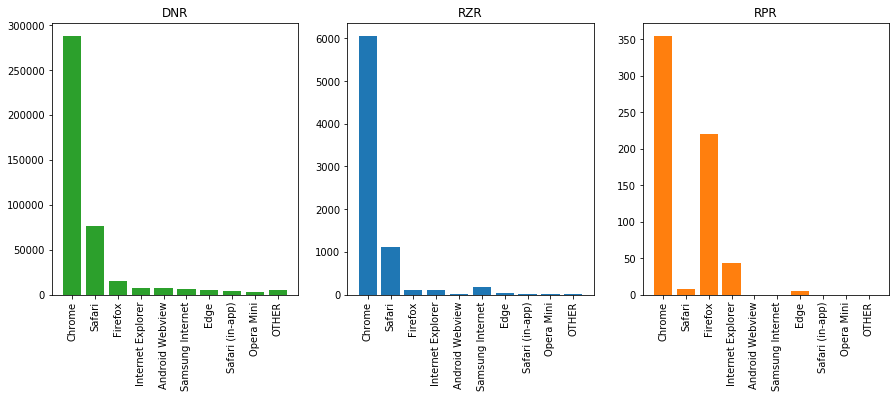

In [38]:
feature = 'device.browser'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>2000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### device.deviceCategory

In [39]:
train_slice['device.deviceCategory'].value_counts(dropna=False)

desktop    262078
mobile     142093
tablet      20975
Name: device.deviceCategory, dtype: int64

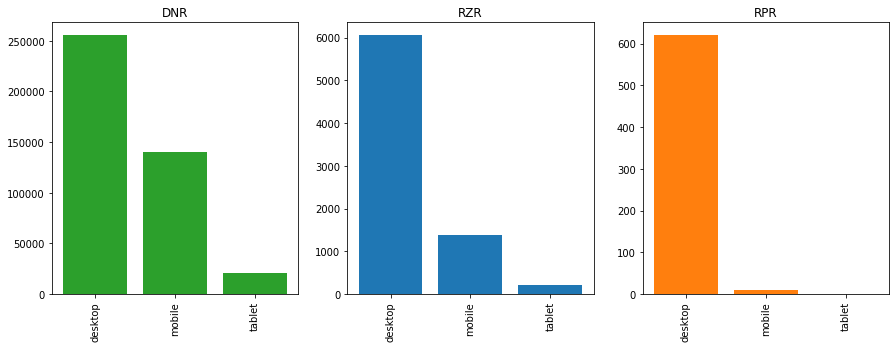

In [40]:
three_bars('device.deviceCategory')

#### device.isMobile

In [41]:
train_slice['device.isMobile'].value_counts(dropna=False)

False    262095
True     163051
Name: device.isMobile, dtype: int64

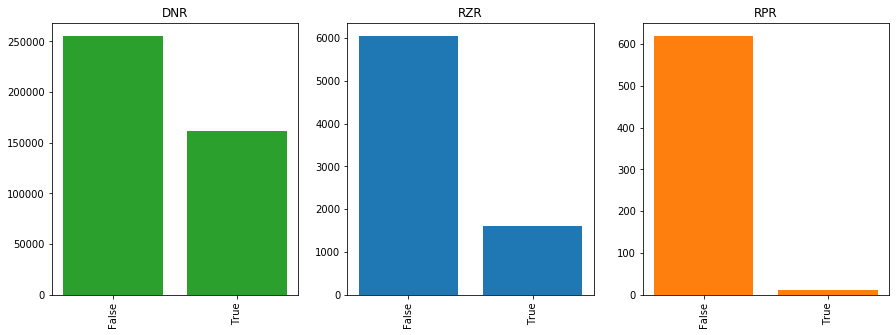

In [42]:
three_bars('device.isMobile')

#### device.operatingSystem

In [43]:
train_slice['device.operatingSystem'].value_counts(dropna=False)

Windows          137316
Macintosh         94959
Android           90809
iOS               68863
Linux             17150
Chrome OS         13038
(not set)          2317
Windows Phone       298
Samsung             187
BlackBerry           92
Tizen                69
Xbox                 24
Nintendo WiiU        10
Firefox OS            7
FreeBSD               3
OS/2                  2
SunOS                 1
Nintendo 3DS          1
Name: device.operatingSystem, dtype: int64

In [44]:
train_slice_RZR['device.operatingSystem'].value_counts(dropna=False)

Macintosh        3320
Windows          1917
iOS               860
Android           728
Linux             528
Chrome OS         291
(not set)          10
BlackBerry          1
Windows Phone       1
Name: device.operatingSystem, dtype: int64

In [45]:
train_slice_RPR['device.operatingSystem'].value_counts(dropna=False)

Windows      333
Macintosh    230
Chrome OS     42
Linux         15
iOS            9
Android        1
Name: device.operatingSystem, dtype: int64

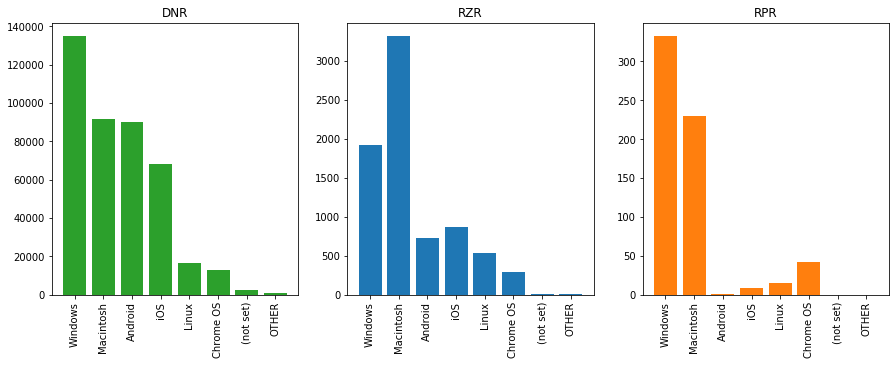

In [46]:
feature = 'device.operatingSystem'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>1000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### geoNetwork.continent

In [47]:
train_slice['geoNetwork.continent'].value_counts(dropna=False)

Americas     235007
Europe        88486
Asia          87414
Oceania        8166
Africa         5518
(not set)       555
Name: geoNetwork.continent, dtype: int64

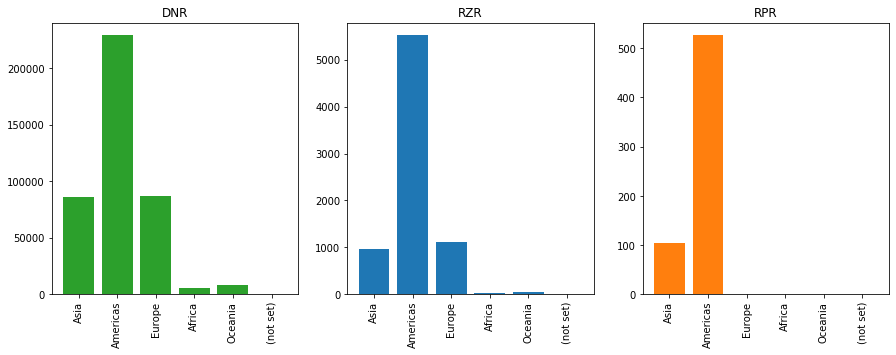

In [48]:
three_bars('geoNetwork.continent')

#### geoNetwork.subContinent

In [49]:
train_slice['geoNetwork.subContinent'].value_counts(dropna=False)

Northern America      210327
Northern Europe        30698
Southern Asia          29455
Western Europe         27801
Southeast Asia         24003
Eastern Asia           23462
South America          16558
Eastern Europe         15169
Southern Europe        14818
Western Asia           10223
Australasia             8074
Central America         7115
Northern Africa         2147
Western Africa          1372
Caribbean               1007
Southern Africa          946
Eastern Africa           906
(not set)                555
Central Asia             271
Middle Africa            147
Micronesian Region        46
Melanesia                 34
Polynesia                 12
Name: geoNetwork.subContinent, dtype: int64

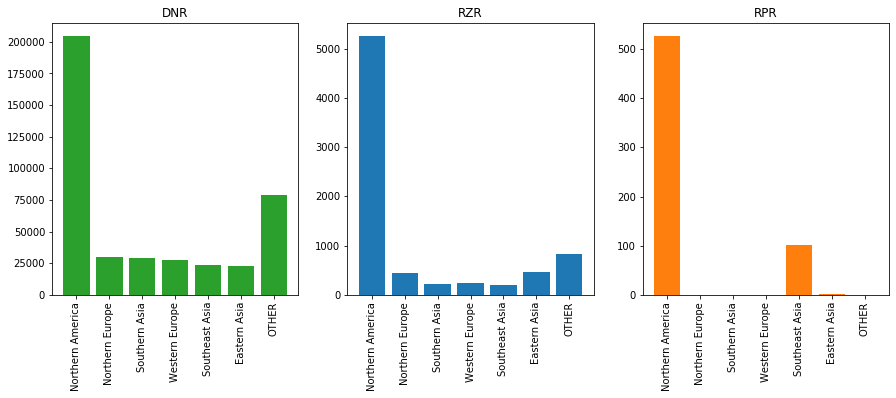

In [50]:
feature = 'geoNetwork.subContinent'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>20000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### geoNetwork.city

In [51]:
train_slice['geoNetwork.city'].value_counts(dropna=False)

not available in demo dataset    232461
Mountain View                     19571
(not set)                         16138
New York                          13573
San Francisco                     10003
                                  ...  
Santa Cruz                            4
Thornton                              3
Saratoga                              3
Newark                                3
Burlingame                            1
Name: geoNetwork.city, Length: 437, dtype: int64

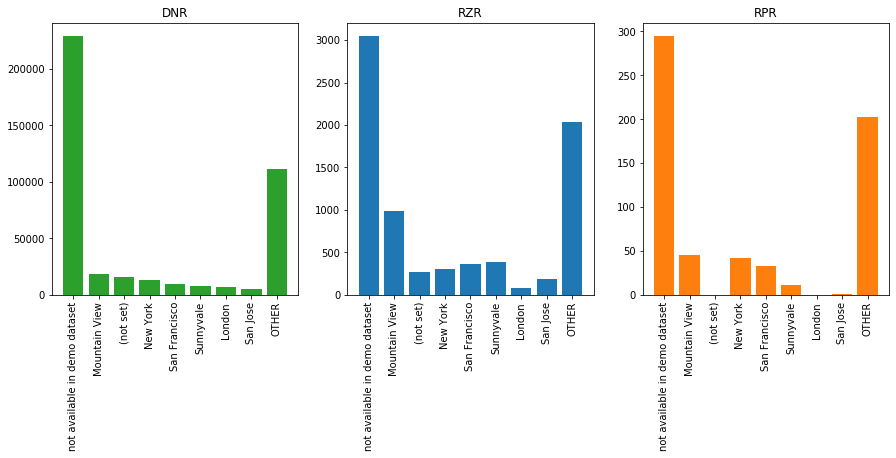

In [52]:
feature = 'geoNetwork.city'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>5000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### geoNetwork.networkDomain

In [53]:
train_slice['geoNetwork.networkDomain'].value_counts(dropna=False)

(not set)               141303
unknown.unknown          60764
comcast.net              13679
rr.com                    7901
verizon.net               7092
                         ...  
gaettc.org                   1
sprinz.eu                    1
unimedmaringa.com.br         1
cegecom.lu                   1
keystone-corp.com            1
Name: geoNetwork.networkDomain, Length: 17202, dtype: int64

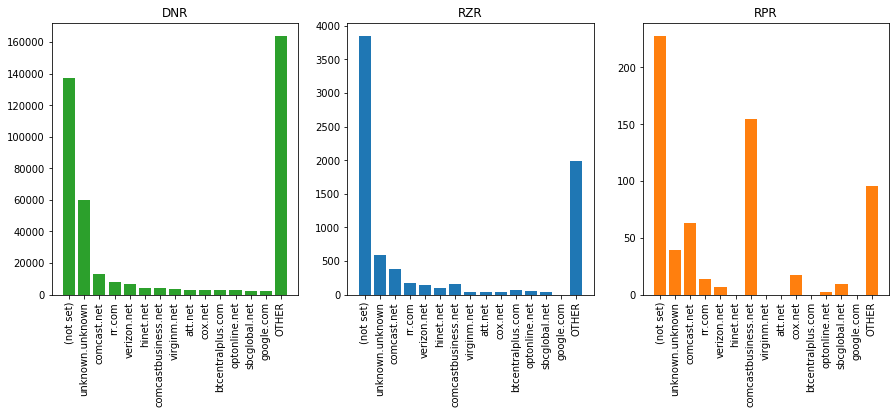

In [54]:
feature = 'geoNetwork.networkDomain'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>2000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.adContent

In [55]:
train_slice['trafficSource.adContent'].value_counts(dropna=False)

NaN                                   389262
Google Merchandise Store               30477
Google Merchandise Collection           3247
Google Online Store                      711
Display Ad created 3/11/14               564
{KeyWord:Google Brand Items}             149
{KeyWord:Google Merchandise}             129
{KeyWord:Google Branded Gear}             58
{KeyWord:Looking for Google Bags?}        55
Display Ad created 11/17/14               50
Bags 300x250                              43
{KeyWord:Want Google Stickers?}           41
Placement Office 300x250                  40
Swag with Google Logos                    37
{KeyWord:Google Drinkware}                28
Placement Elecronics 300 x 250            27
Bags 336x280                              25
Official Google Merchandise               24
{KeyWord:Google Men's T-Shirts}           21
Placement Accessories 300 x 250           20
Placement 336x280                         16
Placement Drinkware 300x250               16
Office Pla

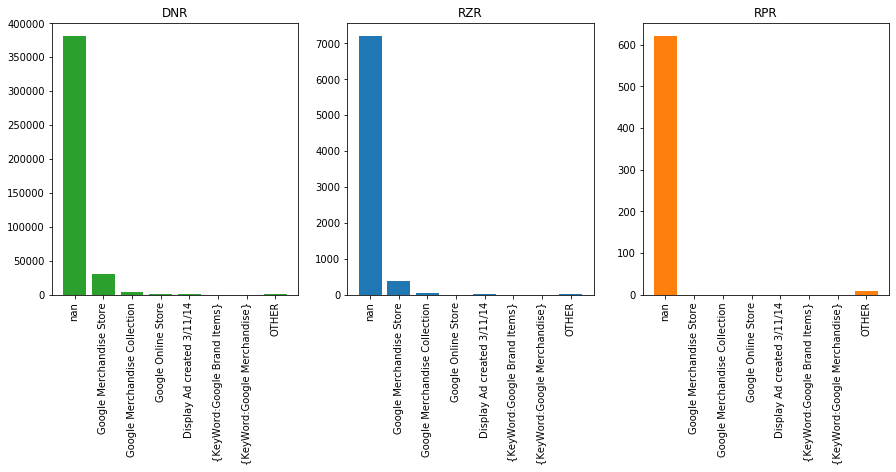

In [56]:
feature = 'trafficSource.adContent'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>100].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.adwordsClickInfo.adNetworkType

In [57]:
train_slice['trafficSource.adwordsClickInfo.adNetworkType'].value_counts(dropna=False)

NaN                382970
Content             30470
Google Search       11705
Search partners         1
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64

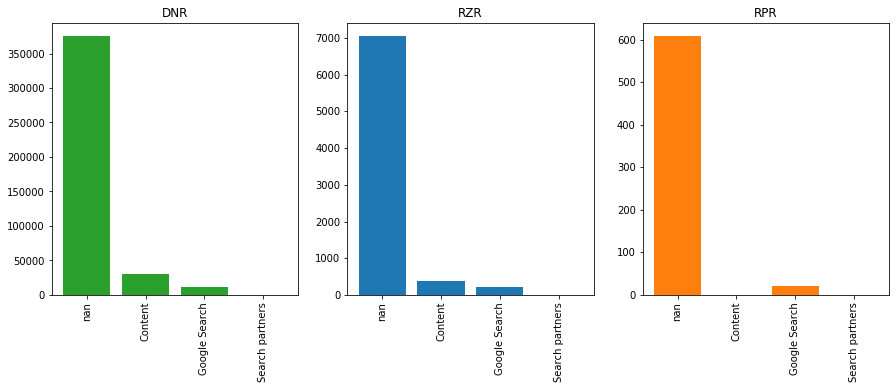

In [58]:
three_bars('trafficSource.adwordsClickInfo.adNetworkType')

#### trafficSource.adwordsClickInfo.page

In [59]:
train_slice['trafficSource.adwordsClickInfo.page'].value_counts(dropna=False)

NaN    382970
1.0     42020
2.0       124
3.0        17
4.0         7
6.0         4
5.0         2
7.0         1
8.0         1
Name: trafficSource.adwordsClickInfo.page, dtype: int64

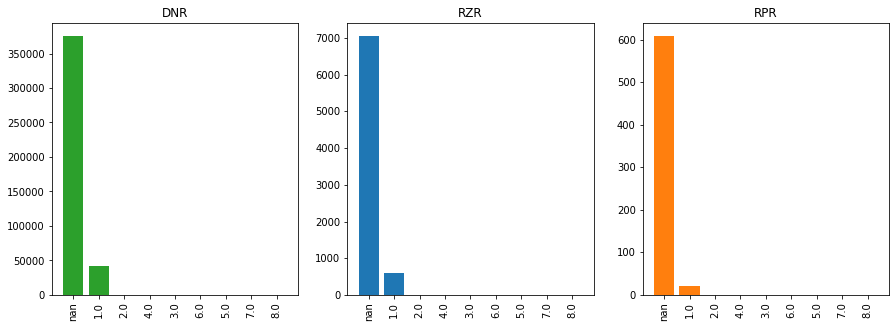

In [60]:
three_bars('trafficSource.adwordsClickInfo.page')

#### trafficSource.adwordsClickInfo.slot

In [61]:
train_slice['trafficSource.adwordsClickInfo.slot'].value_counts(dropna=False)

NaN    382970
RHS     30674
Top     11502
Name: trafficSource.adwordsClickInfo.slot, dtype: int64

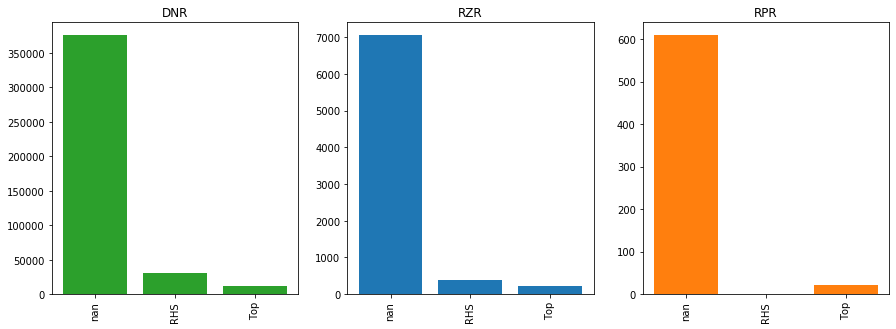

In [62]:
three_bars('trafficSource.adwordsClickInfo.slot')

#### trafficSource.adwordsClickInfo.gclId

In [63]:
train_slice['trafficSource.adwordsClickInfo.gclId'].value_counts(dropna=False)

NaN                                                                                           382921
Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ        70
CIO5_PiPrdYCFVy4wAodz5AMnQ                                                                        32
CICznoPNs9YCFVhWDQodZuUA1Q                                                                        25
CP273vOzr9YCFQEHaQoduBgHSA                                                                        25
                                                                                               ...  
CLWDs9nR3dYCFQNAhgodIdEPmw                                                                         1
EAIaIQobChMI8svDyYzt1gIVTwaGCh0hawvFEAAYASAAEgKK8_D_BwE                                            1
CMLk6sDnqtYCFUQaaQodhugArw                                                                         1
CJGp9rWl39YCFdgXgQodzK0B8w                                                                 

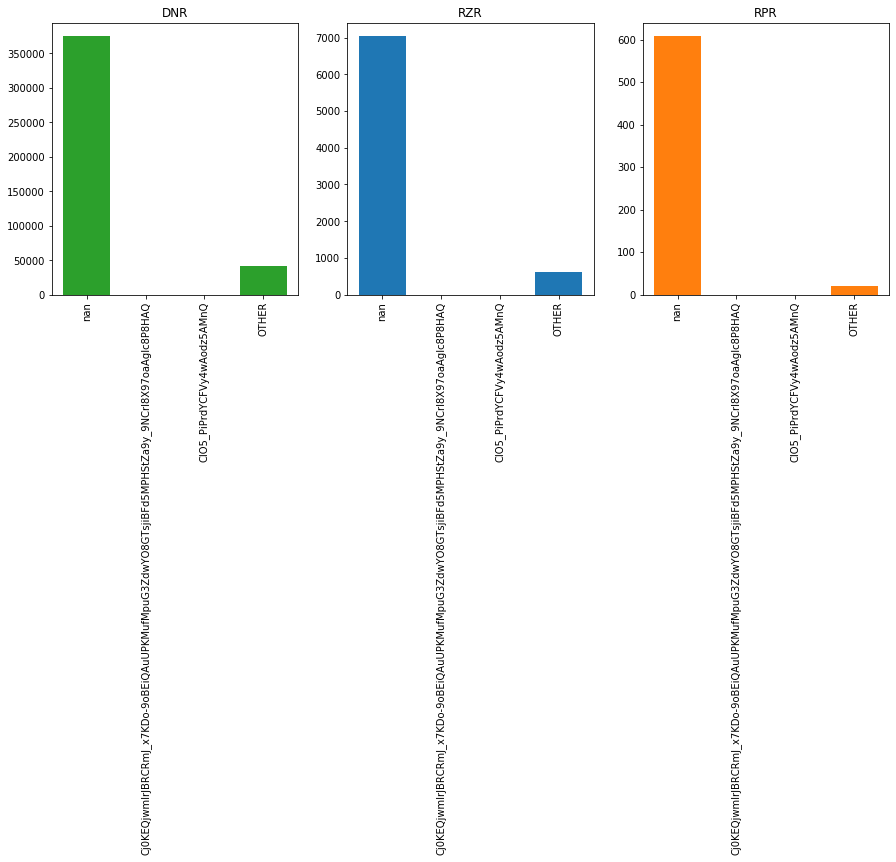

In [64]:
feature = 'trafficSource.adwordsClickInfo.gclId'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>30].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.medium

In [65]:
train_slice['trafficSource.medium'].value_counts(dropna=False)

organic      185748
(none)       127852
referral      59680
cpc           41231
affiliate      7807
cpm            2820
(not set)         8
Name: trafficSource.medium, dtype: int64

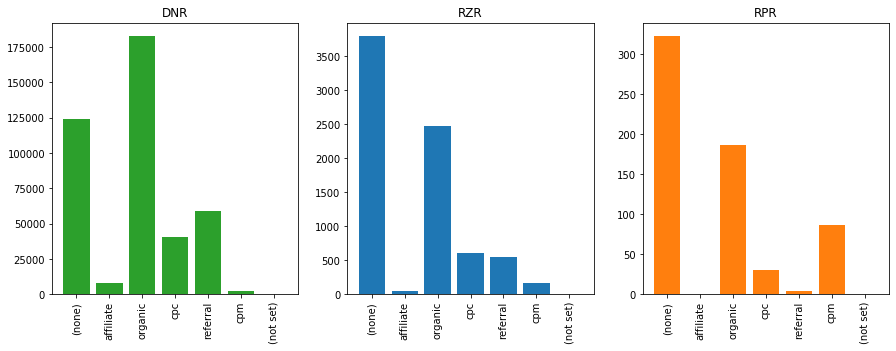

In [66]:
three_bars('trafficSource.medium')

#### trafficSource.campaign

In [67]:
train_slice['trafficSource.campaign'].value_counts(dropna=False)

(not set)                                                 376694
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS     18190
1000557 | GA | US | en | Hybrid | GDN Remarketing          12280
Data Share Promo                                            7807
AW - Dynamic Search Ads Whole Site                          6846
AW - Accessories                                            3068
Page: contains "/google+redesign/office"                      55
Page: contains "/google+redesign/bags" All Users              54
Page: contains "/google+redesign/electronics"                 52
AW - Apparel                                                  25
Page: contains "/google+redesign/bags" 1 Day                  23
Page: contains "/google+redesign/drinkware"                   22
"google + redesign/Accessories March 17" All Users            19
"google + redesign/Accessories March 17" 1 Day                 5
(direct)                                                       4
AW - Electronics         

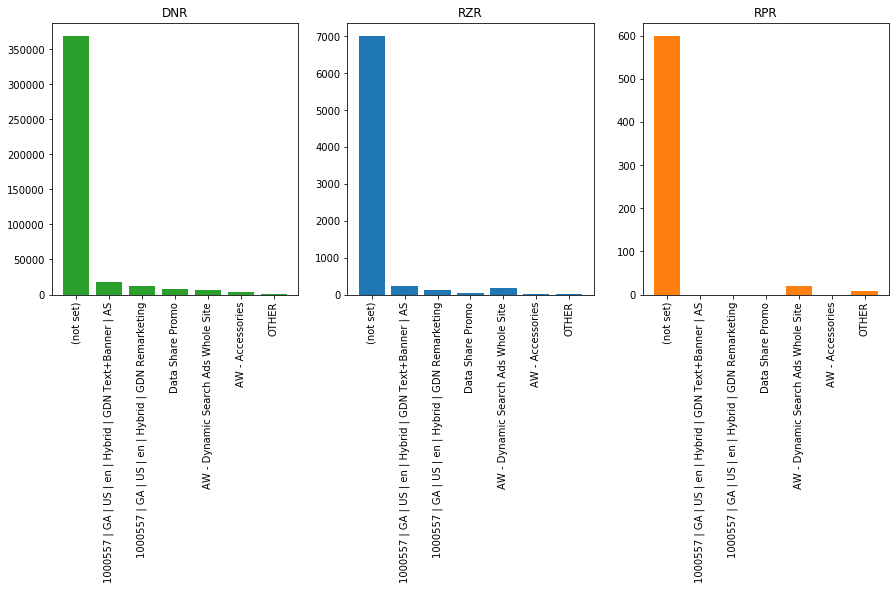

In [68]:
feature = 'trafficSource.campaign'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>1000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.keyword

In [69]:
train_slice['trafficSource.keyword'].value_counts(dropna=False)

NaN                          201282
(not provided)               178408
(User vertical targeting)     17346
(automatic matching)          12225
6qEhsCssdK0z36ri               4685
                              ...  
Shiarts youtub                    1
gogle store                       1
you tube to                       1
yutubbe                           1
you yutbe                         1
Name: trafficSource.keyword, Length: 2158, dtype: int64

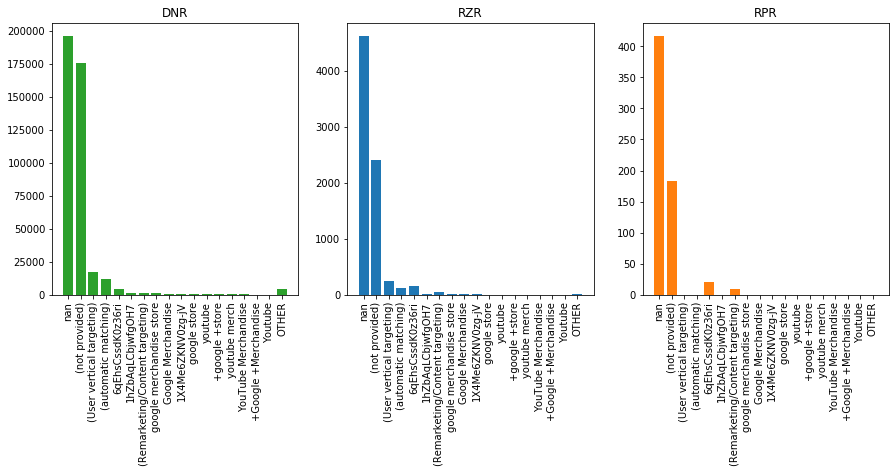

In [70]:
feature = 'trafficSource.keyword'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>100].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.referralPath

In [71]:
train_slice['trafficSource.referralPath'].value_counts(dropna=False)

NaN                                                                                                                                                                       330915
/                                                                                                                                                                          39676
/analytics/web/                                                                                                                                                            10043
/yt/about/                                                                                                                                                                  4470
/yt/about/copyright/                                                                                                                                                        2848
                                                                                                                   

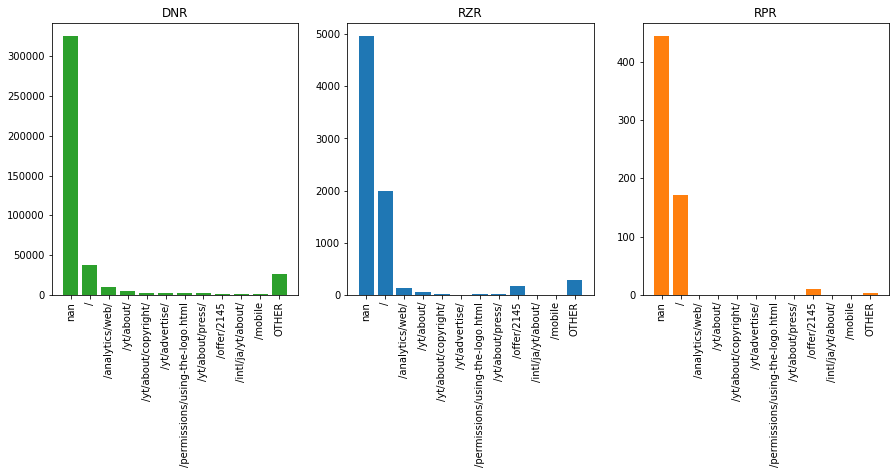

In [72]:
feature = 'trafficSource.referralPath'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>1000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### trafficSource.source

In [73]:
train_slice['trafficSource.source'].value_counts(dropna=False)[:20]

google                  226021
(direct)                127862
youtube.com              32703
analytics.google.com     10000
Partners                  7808
m.facebook.com            3570
google.com                2092
sites.google.com          1272
dfa                       1258
facebook.com              1159
reddit.com                1028
baidu                     1019
qiita.com                  868
quora.com                  837
bing                       768
t.co                       766
groups.google.com          590
mail.google.com            584
yahoo                      579
l.facebook.com             521
Name: trafficSource.source, dtype: int64

In [74]:
train_slice_RPR['trafficSource.source'].value_counts(dropna=False)

(direct)             323
google               216
dfa                   87
groups.google.com      4
Name: trafficSource.source, dtype: int64

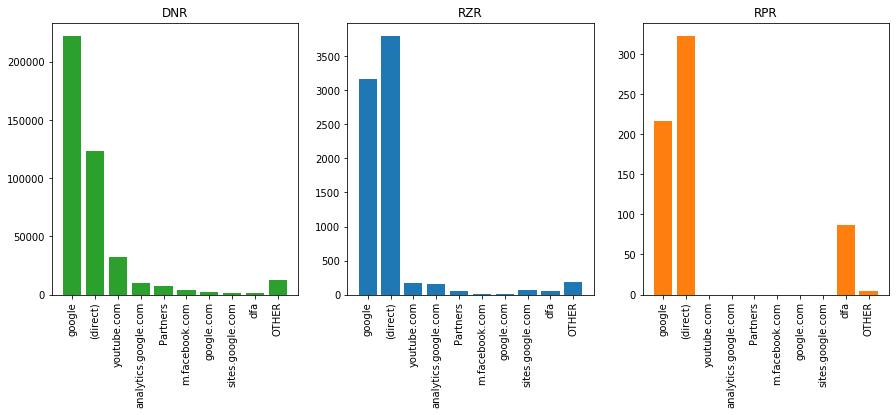

In [75]:
feature = 'trafficSource.source'

value_counts = train_slice[feature].value_counts(dropna=False)

unique_vals = value_counts[value_counts>1200].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

#### visitStartTime_day

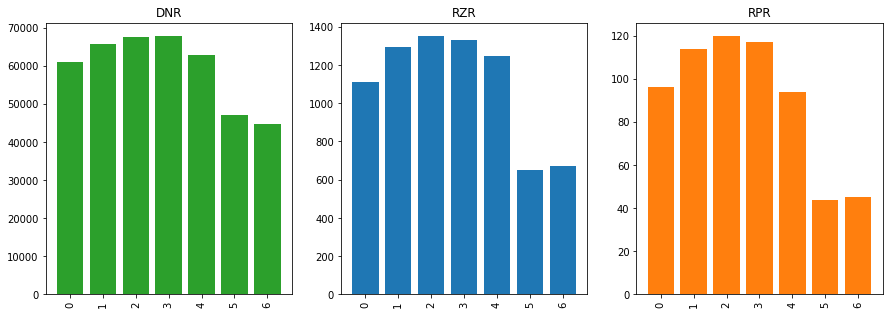

In [76]:
feature = 'visitStartTime_day'

unique_vals = train_slice[feature].unique()
unique_vals = np.sort(unique_vals)
n_vals = len(unique_vals)

val_counts_DNR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
    else:
        val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])

val_counts_RZR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
    else:
        val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])

val_counts_RPR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
    else:
        val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
ax[0].set_xticks(np.arange(n_vals))
ax[0].set_xticklabels(unique_vals, rotation=90)
ax[0].set_title('DNR')

ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
ax[1].set_xticks(np.arange(n_vals))
ax[1].set_xticklabels(unique_vals, rotation=90)
ax[1].set_title('RZR')

ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
ax[2].set_xticks(np.arange(n_vals))
ax[2].set_xticklabels(unique_vals, rotation=90)
ax[2].set_title('RPR')

plt.show(fig)

#### visitStartTime_month

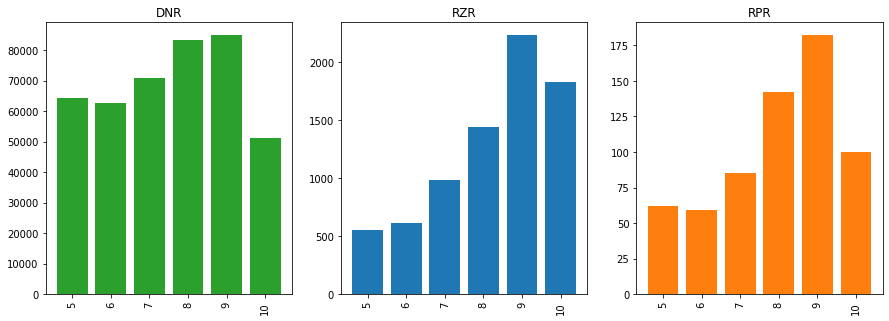

In [77]:
feature = 'visitStartTime_month'

unique_vals = train_slice[feature].unique()
unique_vals = np.sort(unique_vals)
n_vals = len(unique_vals)

val_counts_DNR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature].isnull()])
    else:
        val_counts_DNR[i] = len(train_slice_DNR[train_slice_DNR[feature]==unique_vals[i]])

val_counts_RZR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature].isnull()])
    else:
        val_counts_RZR[i] = len(train_slice_RZR[train_slice_RZR[feature]==unique_vals[i]])

val_counts_RPR = np.zeros(n_vals)
for i in range(n_vals):
    if pd.isnull(unique_vals[i]):
        val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature].isnull()])
    else:
        val_counts_RPR[i] = len(train_slice_RPR[train_slice_RPR[feature]==unique_vals[i]])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].bar(np.arange(n_vals),val_counts_DNR,color='C2')
ax[0].set_xticks(np.arange(n_vals))
ax[0].set_xticklabels(unique_vals, rotation=90)
ax[0].set_title('DNR')

ax[1].bar(np.arange(n_vals),val_counts_RZR,color='C0')
ax[1].set_xticks(np.arange(n_vals))
ax[1].set_xticklabels(unique_vals, rotation=90)
ax[1].set_title('RZR')

ax[2].bar(np.arange(n_vals),val_counts_RPR,color='C1')
ax[2].set_xticks(np.arange(n_vals))
ax[2].set_xticklabels(unique_vals, rotation=90)
ax[2].set_title('RPR')

plt.show(fig)

### Continuous features

#### visitStartTime_hour

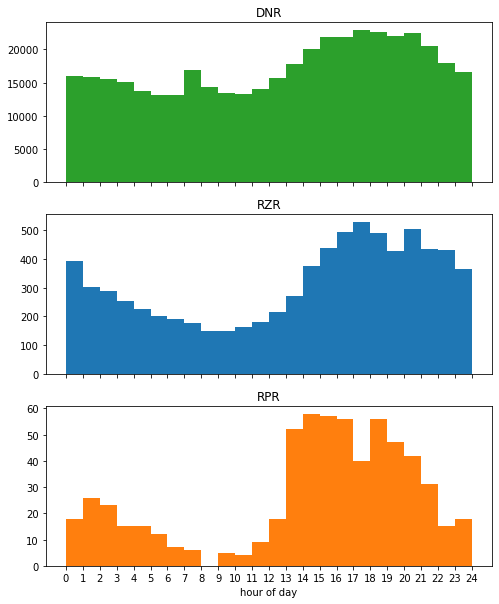

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

bins = np.arange(25)

ax[0].hist(train_slice_DNR['visitStartTime_hour'], bins=bins, color='C2')
ax[0].set_title('DNR')

ax[1].hist(train_slice_RZR['visitStartTime_hour'], bins=bins, color='C0')
ax[1].set_title('RZR')

ax[2].hist(train_slice_RPR['visitStartTime_hour'], bins=bins, color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('hour of day')

ax[2].set_xticks(bins)

plt.show(fig)

R^2    = 0.0022532834746234708
p-val. = 0.2341403091168508


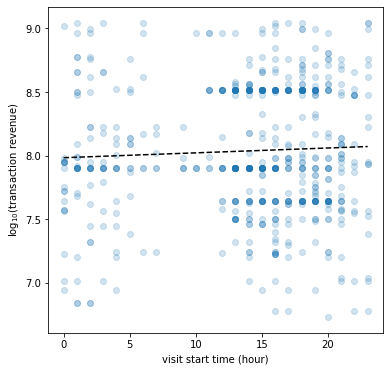

In [79]:
fig, ax = plt.subplots(figsize=(6,6))

x = train_slice_RPR['visitStartTime_hour']
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('visit start time (hour)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.hits

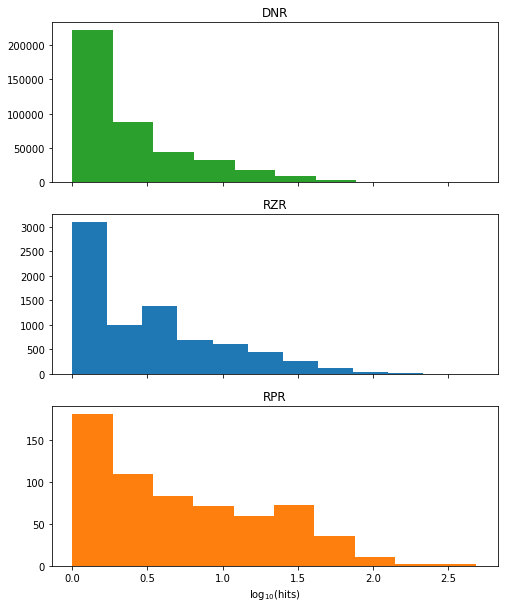

In [80]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_slice_DNR['totals.hits']), color='C2')
ax[0].set_title('DNR')

ax[1].hist(np.log10(train_slice_RZR['totals.hits']), color='C0')
ax[1].set_title('RZR')

ax[2].hist(np.log10(train_slice_RPR['totals.hits']), color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('log$_{10}$(hits)')

plt.show(fig)

R^2    = 0.037234198164373254
p-val. = 1.062947326890232e-06


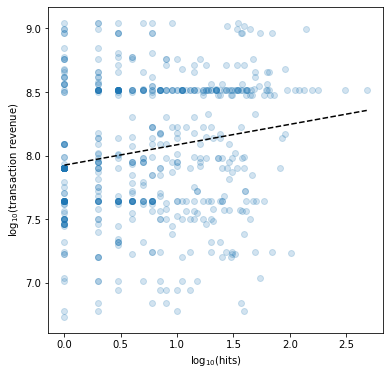

In [81]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_slice_RPR['totals.hits'])
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(hits)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.pageviews

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


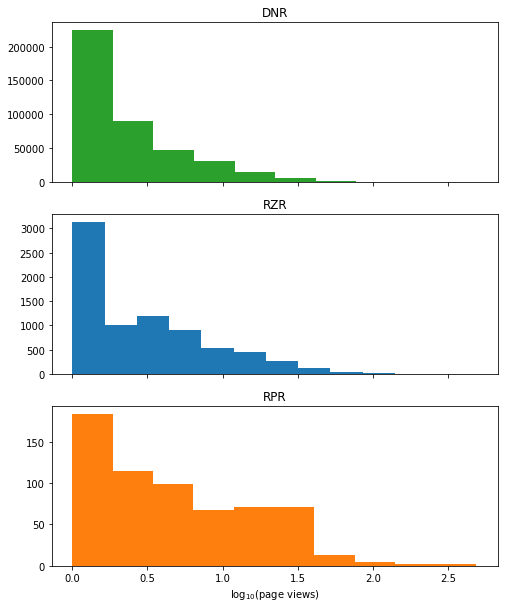

In [82]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_slice_DNR['totals.pageviews']), color='C2')
ax[0].set_title('DNR')

ax[1].hist(np.log10(train_slice_RZR['totals.pageviews']), color='C0')
ax[1].set_title('RZR')

ax[2].hist(np.log10(train_slice_RPR['totals.pageviews']), color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('log$_{10}$(page views)')

plt.show(fig)

R^2    = 0.044547308366946974
p-val. = 8.919896656894077e-08


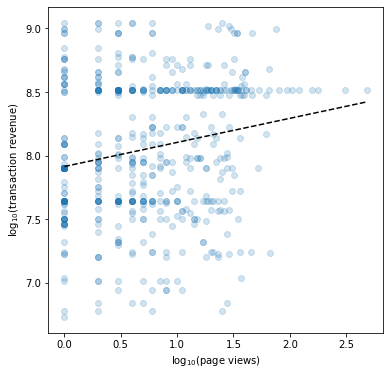

In [83]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_slice_RPR['totals.pageviews'])
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(page views)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

#### totals.sessionQualityDim

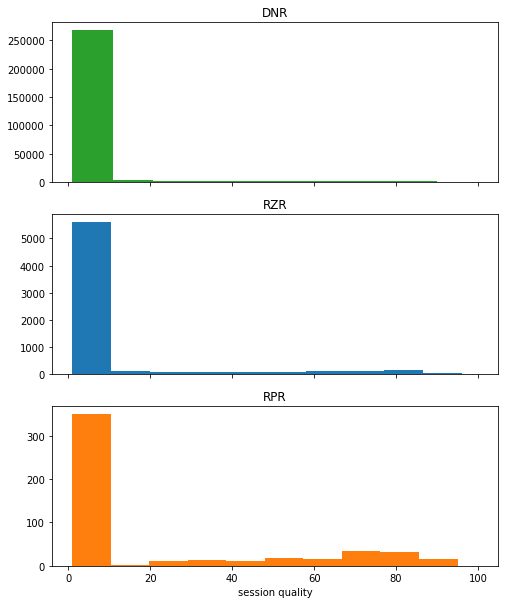

In [84]:
if 'totals.sessionQualityDim' in train_slice.columns:

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

    ax[0].hist(train_slice_DNR['totals.sessionQualityDim'], color='C2')
    ax[0].set_title('DNR')

    ax[1].hist(train_slice_RZR['totals.sessionQualityDim'], color='C0')
    ax[1].set_title('RZR')

    ax[2].hist(train_slice_RPR['totals.sessionQualityDim'], color='C1')
    ax[2].set_title('RPR')

    ax[2].set_xlabel('session quality')

    plt.show(fig)
    
else:
    print('totals.sessionQualityDim not in this slice.')

R^2    = nan
p-val. = nan


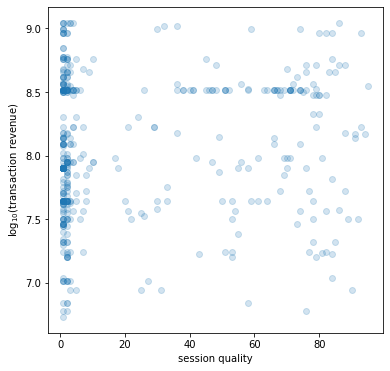

In [85]:
if 'totals.sessionQualityDim' in train_slice.columns:

    fig, ax = plt.subplots(figsize=(6,6))

    x = train_slice_RPR['totals.sessionQualityDim']
    y = np.log10(train_slice_RPR['total_predict_revenue'])

    x_line = np.array([np.min(x), np.max(x)])

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('R^2    = {}'.format(r_value**2))
    print('p-val. = {}'.format(p_value))

    ax.scatter(x, y, alpha=0.2, c='C0')
    ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

    ax.set_xlabel('session quality')
    ax.set_ylabel('log$_{10}$(transaction revenue)')

    plt.show(fig)
    
else:
    print('totals.sessionQualityDim not in this slice.')

#### totals.timeOnSite

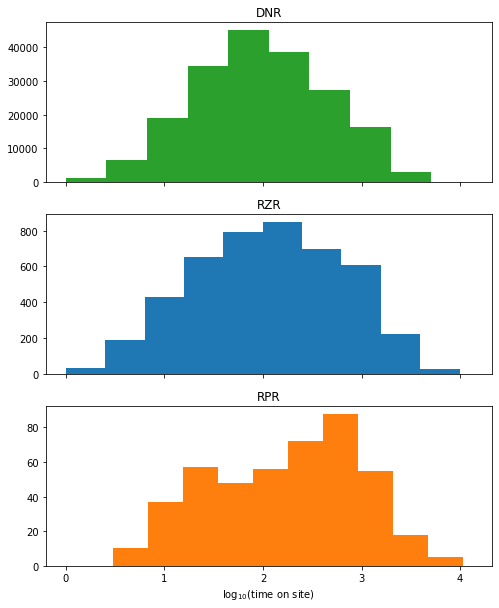

In [86]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)

ax[0].hist(np.log10(train_slice_DNR['totals.timeOnSite']), color='C2')
ax[0].set_title('DNR')

ax[1].hist(np.log10(train_slice_RZR['totals.timeOnSite']), color='C0')
ax[1].set_title('RZR')

ax[2].hist(np.log10(train_slice_RPR['totals.timeOnSite']), color='C1')
ax[2].set_title('RPR')

ax[2].set_xlabel('log$_{10}$(time on site)')

plt.show(fig)

R^2    = nan
p-val. = nan


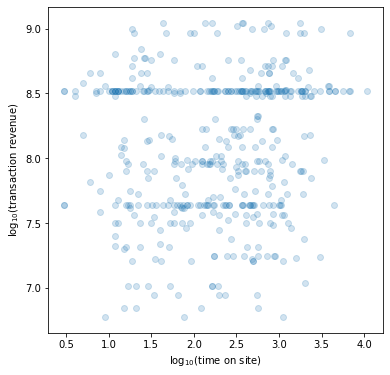

In [87]:
fig, ax = plt.subplots(figsize=(6,6))

x = np.log10(train_slice_RPR['totals.timeOnSite'])
y = np.log10(train_slice_RPR['total_predict_revenue'])

x_line = np.array([np.min(x), np.max(x)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('R^2    = {}'.format(r_value**2))
print('p-val. = {}'.format(p_value))

ax.scatter(x, y, alpha=0.2, c='C0')
ax.plot(x_line, x_line*slope + intercept, c='k', ls='--')

ax.set_xlabel('log$_{10}$(time on site)')
ax.set_ylabel('log$_{10}$(transaction revenue)')

plt.show(fig)

## Feature Engineering

* channelGrouping
* device.browser
* device.operatingSystem
* geoNetwork.subContinent
* trafficSource.medium
* trafficSource.source
* visitStartTime_month
* visitStartTime_hour
* totals.hits
* totals.pageviews
* totals.sessionQualityDim
* totals.timeOnSite

First, create a column with the unique visitor ID's, sorted:

In [88]:
train_df = pd.DataFrame()

train_df['fullVisitorId'] = train_slice['fullVisitorId'].unique()
train_df.sort_values(by='fullVisitorId', inplace=True)
train_df.reset_index(inplace=True, drop=True)

### channelGrouping

One hot encode, summing for multiple visits from a single visitor.

In [89]:
feature = 'channelGrouping'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(train_slice[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### device.browser

One hot encode, summing for multiple visits from a single visitor.

In [90]:
feature = 'device.browser'

# get the categories that won't be grouped under OTHER
unique_vals = ['Chrome',
               'Safari',
               'Firefox',
               'Internet Explorer',
               'Android Webview']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
feature_df[feature] = train_slice[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### device.operatingSystem

One hot encode, summing for multiple visits from a single visitor.

In [91]:
feature = 'device.operatingSystem'

# get the categories that won't be grouped under OTHER
unique_vals = ['Windows',
               'Macintosh',
               'Android',
               'iOS',
               'Linux',
               'Chrome OS',
               '(not set)']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
feature_df[feature] = train_slice[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### geoNetwork.subContinent

One hot encode, summing for multiple visits from a single visitor.

In [92]:
feature = 'geoNetwork.subContinent'

# get the categories that won't be grouped under OTHER
unique_vals = ['Northern America',
               'Northern Europe',
               'Southern Asia',
               'Western Europe',
               'Southeast Asia',
               'Eastern Asia']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
feature_df[feature] = train_slice[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### trafficSource.medium

One hot encode, summing for multiple visits from a single visitor.

In [93]:
feature = 'trafficSource.medium'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(train_slice[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### trafficSource.source

One hot encode, summing for multiple visits from a single visitor.

In [94]:
feature = 'trafficSource.source'

# get the categories that won't be grouped under OTHER
unique_vals = ['google',
               '(direct)',
               'youtube.com',
               'analytics.google.com',
               'Partners',
               'm.facebook.com',
               'google.com',
               'sites.google.com',
               'dfa']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
feature_df[feature] = train_slice[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### period

One hot encode, summing for multiple visits from a single visitor. Also gradient column.

In [95]:
feature = 'period'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(train_slice[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + str(np.int(LB.classes_[i])))
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

In [96]:
# gradient from linear regression
period_gradient = np.zeros(len(train_df))

x = np.array([1,2,3,4])
for i in tqdm_notebook(range(len(train_df))):
    y = feature_df_summed.values[i]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    period_gradient[i] = slope
    
train_df[feature + '_gradient'] = period_gradient

### visitStartTime_hour

Divide into morning, afternoon, evening, then one hot encode, summing for multiple visits from a single visitor.

In [97]:
# assign morning vs. evening
train_slice.loc[(train_slice['visitStartTime_hour']>=3) & (train_slice['visitStartTime_hour']<13), 'TOD']='morning'
train_slice.loc[(train_slice['visitStartTime_hour']>=13) & (train_slice['visitStartTime_hour']<21), 'TOD']='afternoon'
train_slice.loc[train_slice['TOD'].isnull(), 'TOD']='evening'

In [98]:
feature = 'TOD'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(train_slice[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### totals.hits

Sum for each visitor.

In [99]:
feature = 'totals.hits'

# create a temporary dataframe
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId'],
                           feature:train_slice[feature]})

# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### totals.sessionQualityDim

Average for each visitor.

In [100]:
if 'totals.sessionQualityDim' in train_slice.columns:

    feature = 'totals.sessionQualityDim'

    # create a temporary dataframe
    feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId'],
                               feature:train_slice[feature]})

    # group by each unique visitor, averaging
    feature_df_summed = feature_df.groupby('fullVisitorId').mean()

    # build up the training dataframe
    train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')
    
else:
    print('totals.sessionQualityDim not in this slice.')

### totals.timeOnSite

Sum for each visitor.

In [101]:
feature = 'totals.timeOnSite'

# create a temporary dataframe
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId'],
                           feature:train_slice[feature]})

# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### totals.transactionRevenue

Divide into each time period, then sum for multiple visits from a single visitor. Also gradient column.

In [102]:
feature = 'totals.transactionRevenue'

# iterate over each period
period_vals = np.array([1,2,3,4])
for i in range(4):
    train_period_slice = train_slice[train_slice['period']==period_vals[i]]
    
    # create a temporary dataframe
    feature_df = pd.DataFrame({'fullVisitorId':train_period_slice['fullVisitorId'],
                               feature + '_' + str(i+1):train_period_slice[feature]})
    
    # group by each unique visitor, summing
    feature_df_summed = feature_df.groupby('fullVisitorId').sum()
    
    # build up the training dataframe
    train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId')
    
# convert NaN to 0
train_df.loc[train_df[feature + '_1'].isnull(), feature + '_1'] = 0
train_df.loc[train_df[feature + '_2'].isnull(), feature + '_2'] = 0
train_df.loc[train_df[feature + '_3'].isnull(), feature + '_3'] = 0
train_df.loc[train_df[feature + '_4'].isnull(), feature + '_4'] = 0

In [103]:
# gradient from linear regression
period_gradient = np.zeros(len(train_df))

col_names = [feature + '_1', feature + '_2',feature + '_3',feature + '_4']

val_array = train_df[col_names].values

x = np.array([1,2,3,4])
for i in tqdm_notebook(range(len(train_df))):
    y = val_array[i]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    period_gradient[i] = slope
    
train_df[feature + '_gradient'] = period_gradient

In [104]:
feature = 'totals.transactionRevenue'

# create a temporary dataframe
feature_df = pd.DataFrame({'fullVisitorId':train_slice['fullVisitorId'],
                           feature:train_slice[feature]})

# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
train_df = train_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### Target

In [105]:
# merge the prediction and training slices on the full-visitor ID
train_df = train_df.merge(target, how='left', on='fullVisitorId')

# return flag
train_df.loc[train_df['total_predict_revenue'].isnull(), 'return_flag'] = 0
train_df.loc[train_df['return_flag'].isnull(), 'return_flag'] = 1

# convert NaN to 0
train_df.loc[train_df['total_predict_revenue'].isnull(), 'total_predict_revenue'] = 0

In [106]:
print('Return             : {}'.format(np.sum(train_df['return_flag']==1)))
print('Return and Revenue : {}'.format(np.sum(train_df['total_predict_revenue']!=0)))

Return             : 2590
Return and Revenue : 109


### Clean Up

In [107]:
for col in train_df.columns:
    n_nans = np.sum(train_df[col].isnull())
    if n_nans!=0:
        print(col)
        print(n_nans)
        print('----------')

totals.sessionQualityDim
102793
----------


Impute:

In [108]:
if 'totals.sessionQualityDim' in train_slice.columns:

    # convert NaN to mean value
    mean_val = np.nanmean(train_df['totals.sessionQualityDim'])
    train_df.loc[train_df['totals.sessionQualityDim'].isnull(), 'totals.sessionQualityDim'] = mean_val
    
else:
    print('totals.sessionQualityDim not in this slice.')

Save:

In [109]:
train_df.to_csv('./data/train_df_'+str_append+'.csv', index=False)

In [110]:
train_df.head()

,fullVisitorId,channelGrouping.(Other),channelGrouping.Affiliates,channelGrouping.Direct,channelGrouping.Display,channelGrouping.Organic Search,channelGrouping.Paid Search,channelGrouping.Referral,channelGrouping.Social,device.browser.Android Webview,device.browser.Chrome,device.browser.Firefox,device.browser.Internet Explorer,device.browser.OTHER,device.browser.Safari,device.operatingSystem.(not set),device.operatingSystem.Android,device.operatingSystem.Chrome OS,device.operatingSystem.Linux,device.operatingSystem.Macintosh,device.operatingSystem.OTHER,device.operatingSystem.Windows,device.operatingSystem.iOS,geoNetwork.subContinent.Eastern Asia,geoNetwork.subContinent.Northern America,geoNetwork.subContinent.Northern Europe,geoNetwork.subContinent.OTHER,geoNetwork.subContinent.Southeast Asia,geoNetwork.subContinent.Southern Asia,geoNetwork.subContinent.Western Europe,trafficSource.medium.(none),trafficSource.medium.(not set),trafficSource.medium.affiliate,trafficSource.medium.cpc,trafficSource.medium.cpm,trafficSource.medium.organic,trafficSource.medium.referral,trafficSource.source.(direct),trafficSource.source.OTHER,trafficSource.source.Partners,trafficSource.source.analytics.google.com,trafficSource.source.dfa,trafficSource.source.google,trafficSource.source.google.com,trafficSource.source.m.facebook.com,trafficSource.source.sites.google.com,trafficSource.source.youtube.com,period.1,period.2,period.3,period.4,period_gradient,TOD.afternoon,TOD.evening,TOD.morning,totals.hits,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue_1,totals.transactionRevenue_2,totals.transactionRevenue_3,totals.transactionRevenue_4,totals.transactionRevenue_gradient,totals.transactionRevenue,total_predict_revenue,return_flag
0,0000049363351866189,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0.9,0,2,1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000062267706107999,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-0.1,0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000085059828173212,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.1,0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0000085840370633780,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.3,0,1,0,2,1.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0000091131414287111,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.3,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Test Feature Engineering

Read in data:

In [111]:
if create_slice == True:
    
    # load .csv's back in, but using the loading function to flatten most of the JSON columns
    test = load_df('./data/test_v2.csv')
    print('1/2 : Testing read in.')
    
    # save to .csv
    test.to_csv('./data/test_cleaned.csv', index=False)
    print('2/2 : Cleaned data saved.')
    
else:
    test = pd.read_csv('./data/test_cleaned.csv',
                       dtype={'fullVisitorId':'str'})

Pull out some start time information:

In [112]:
test['visitStartTime_hour'] = pd.to_datetime(test['visitStartTime'], unit='s').dt.hour
test['visitStartTime_day'] = pd.to_datetime(test['visitStartTime'], unit='s').dt.weekday
test['visitStartTime_month'] = pd.to_datetime(test['visitStartTime'], unit='s').dt.month

Divide into 4 equal time periods - each exactly 6 weeks long:

In [113]:
# set slice dates here
p1_start_date = test_start_date
p1_end_date = p1_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

p2_start_date = p1_end_date + dt.timedelta(days=1)
p2_end_date = p2_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

p3_start_date = p2_end_date + dt.timedelta(days=1)
p3_end_date = p3_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

p4_start_date = p3_end_date + dt.timedelta(days=1)
p4_end_date = p4_start_date + dt.timedelta(days=42) - dt.timedelta(days=1)

# create the column
test_date = pd.to_datetime(test['date'], format='%Y%m%d')

test.loc[(test_date>=p1_start_date) & (test_date<=p1_end_date), 'period'] = 1
test.loc[(test_date>=p2_start_date) & (test_date<=p2_end_date), 'period'] = 2
test.loc[(test_date>=p3_start_date) & (test_date<=p3_end_date), 'period'] = 3
test.loc[(test_date>=p4_start_date) & (test_date<=p4_end_date), 'period'] = 4

First, create a column with the unique visitor ID's, sorted:

In [114]:
test_df = pd.DataFrame()

test_df['fullVisitorId'] = test['fullVisitorId'].unique()
test_df.sort_values(by='fullVisitorId', inplace=True)
test_df.reset_index(inplace=True, drop=True)

### channelGrouping

One hot encode, summing for multiple visits from a single visitor.

In [115]:
feature = 'channelGrouping'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(test[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### device.browser

One hot encode, summing for multiple visits from a single visitor.

In [116]:
feature = 'device.browser'

# get the categories that won't be grouped under OTHER
unique_vals = ['Chrome',
               'Safari',
               'Firefox',
               'Internet Explorer',
               'Android Webview']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
feature_df[feature] = test[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### device.operatingSystem

One hot encode, summing for multiple visits from a single visitor.

In [117]:
feature = 'device.operatingSystem'

# get the categories that won't be grouped under OTHER
unique_vals = ['Windows',
               'Macintosh',
               'Android',
               'iOS',
               'Linux',
               'Chrome OS',
               '(not set)']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
feature_df[feature] = test[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### geoNetwork.subContinent

One hot encode, summing for multiple visits from a single visitor.

In [118]:
feature = 'geoNetwork.subContinent'

# get the categories that won't be grouped under OTHER
unique_vals = ['Northern America',
               'Northern Europe',
               'Southern Asia',
               'Western Europe',
               'Southeast Asia',
               'Eastern Asia']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
feature_df[feature] = test[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### trafficSource.medium

One hot encode, summing for multiple visits from a single visitor.

In [119]:
feature = 'trafficSource.medium'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(test[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### trafficSource.source

One hot encode, summing for multiple visits from a single visitor.

In [120]:
feature = 'trafficSource.source'

# get the categories that won't be grouped under OTHER
unique_vals = ['google',
               '(direct)',
               'youtube.com',
               'analytics.google.com',
               'Partners',
               'm.facebook.com',
               'google.com',
               'sites.google.com',
               'dfa']

# create a temporary dataframe that includes the OTHER category
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
feature_df[feature] = test[feature].copy()
feature_df.loc[~feature_df[feature].isin(unique_vals), feature] = 'OTHER'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(feature_df[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### period

One hot encode, summing for multiple visits from a single visitor. Also gradient column.

In [121]:
feature = 'period'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(test[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + str(np.int(LB.classes_[i])))
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

In [122]:
# gradient from linear regression
period_gradient = np.zeros(len(test_df))

x = np.array([1,2,3,4])
for i in tqdm_notebook(range(len(test_df))):
    y = feature_df_summed.values[i]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    period_gradient[i] = slope
    
test_df[feature + '_gradient'] = period_gradient

### visitStartTime_hour

Divide into morning, afternoon, evening, then one hot encode, summing for multiple visits from a single visitor.

In [123]:
# assign morning vs. evening
test.loc[(test['visitStartTime_hour']>=3) & (test['visitStartTime_hour']<13), 'TOD']='morning'
test.loc[(test['visitStartTime_hour']>=13) & (test['visitStartTime_hour']<21), 'TOD']='afternoon'
test.loc[test['TOD'].isnull(), 'TOD']='evening'

In [124]:
feature = 'TOD'

# one hot encode the feature
LB = LabelBinarizer()
OHE_array = LB.fit_transform(test[feature])

# create new column names
n_classes = len(LB.classes_)
column_names = []
for i in range(n_classes):
    column_names.append(feature + '.' + LB.classes_[i])
    
# create a temporary dataframe with the above
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId']})
for i in range(n_classes):
    feature_df[column_names[i]] = OHE_array[:, i]
    
# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### totals.hits

Sum for each visitor.

In [125]:
feature = 'totals.hits'

# create a temporary dataframe
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'],
                           feature:test[feature]})

# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### totals.sessionQualityDim

Average for each visitor.

In [126]:
if 'totals.sessionQualityDim' in test.columns:

    feature = 'totals.sessionQualityDim'

    # create a temporary dataframe
    feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'],
                               feature:test[feature]})

    # group by each unique visitor, averaging
    feature_df_summed = feature_df.groupby('fullVisitorId').mean()

    # build up the training dataframe
    test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')
    
else:
    print('totals.sessionQualityDim not in this slice.')

### totals.timeOnSite

Sum for each visitor.

In [127]:
feature = 'totals.timeOnSite'

# create a temporary dataframe
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'],
                           feature:test[feature]})

# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### totals.transactionRevenue

Divide into each time period, then sum for multiple visits from a single visitor. Also gradient column.

In [128]:
feature = 'totals.transactionRevenue'

# iterate over each period
period_vals = np.array([1,2,3,4])
for i in range(4):
    train_period_slice = test[test['period']==period_vals[i]]
    
    # create a temporary dataframe
    feature_df = pd.DataFrame({'fullVisitorId':train_period_slice['fullVisitorId'],
                               feature + '_' + str(i+1):train_period_slice[feature]})
    
    # group by each unique visitor, summing
    feature_df_summed = feature_df.groupby('fullVisitorId').sum()
    
    # build up the training dataframe
    test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId')
    
# convert NaN to 0
test_df.loc[test_df[feature + '_1'].isnull(), feature + '_1'] = 0
test_df.loc[test_df[feature + '_2'].isnull(), feature + '_2'] = 0
test_df.loc[test_df[feature + '_3'].isnull(), feature + '_3'] = 0
test_df.loc[test_df[feature + '_4'].isnull(), feature + '_4'] = 0

In [129]:
# gradient from linear regression
period_gradient = np.zeros(len(test_df))

col_names = [feature + '_1', feature + '_2',feature + '_3',feature + '_4']

val_array = test_df[col_names].values

x = np.array([1,2,3,4])
for i in tqdm_notebook(range(len(test_df))):
    y = val_array[i]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    period_gradient[i] = slope
    
test_df[feature + '_gradient'] = period_gradient

In [130]:
feature = 'totals.transactionRevenue'

# create a temporary dataframe
feature_df = pd.DataFrame({'fullVisitorId':test['fullVisitorId'],
                           feature:test[feature]})

# group by each unique visitor, summing
feature_df_summed = feature_df.groupby('fullVisitorId').sum()

# build up the training dataframe
test_df = test_df.merge(feature_df_summed, how='left', on='fullVisitorId', validate='1:1')

### Clean Up

In [131]:
for col in test_df.columns:
    n_nans = np.sum(test_df[col].isnull())
    if n_nans!=0:
        print(col)
        print(n_nans)
        print('----------')

Impute:

In [132]:
if 'totals.sessionQualityDim' in test.columns:

    # convert NaN to mean value
    mean_val = np.nanmean(test_df['totals.sessionQualityDim'])
    test_df.loc[test_df['totals.sessionQualityDim'].isnull(), 'totals.sessionQualityDim'] = mean_val
    
else:
    print('totals.sessionQualityDim not in this slice.')

Save:

In [133]:
test_df.to_csv('./data/test_df.csv', index=False)

In [134]:
test_df.head()

,fullVisitorId,channelGrouping.(Other),channelGrouping.Affiliates,channelGrouping.Direct,channelGrouping.Display,channelGrouping.Organic Search,channelGrouping.Paid Search,channelGrouping.Referral,channelGrouping.Social,device.browser.Android Webview,device.browser.Chrome,device.browser.Firefox,device.browser.Internet Explorer,device.browser.OTHER,device.browser.Safari,device.operatingSystem.(not set),device.operatingSystem.Android,device.operatingSystem.Chrome OS,device.operatingSystem.Linux,device.operatingSystem.Macintosh,device.operatingSystem.OTHER,device.operatingSystem.Windows,device.operatingSystem.iOS,geoNetwork.subContinent.Eastern Asia,geoNetwork.subContinent.Northern America,geoNetwork.subContinent.Northern Europe,geoNetwork.subContinent.OTHER,geoNetwork.subContinent.Southeast Asia,geoNetwork.subContinent.Southern Asia,geoNetwork.subContinent.Western Europe,trafficSource.medium.(none),trafficSource.medium.(not set),trafficSource.medium.affiliate,trafficSource.medium.cpc,trafficSource.medium.cpm,trafficSource.medium.organic,trafficSource.medium.referral,trafficSource.source.(direct),trafficSource.source.OTHER,trafficSource.source.Partners,trafficSource.source.analytics.google.com,trafficSource.source.dfa,trafficSource.source.google,trafficSource.source.google.com,trafficSource.source.m.facebook.com,trafficSource.source.sites.google.com,trafficSource.source.youtube.com,period.1,period.2,period.3,period.4,period_gradient,TOD.afternoon,TOD.evening,TOD.morning,totals.hits,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue_1,totals.transactionRevenue_2,totals.transactionRevenue_3,totals.transactionRevenue_4,totals.transactionRevenue_gradient,totals.transactionRevenue
0,0000018966949534117,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.1,0,0,1,7,1.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000039738481224681,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.1,0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000073585230191399,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,-0.3,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0000087588448856385,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,-0.3,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0000149787903119437,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,-0.3,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
